In [98]:
# import necessary libraries


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
plt.rcParams.update({'font.size': 22})

In [99]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [100]:
# read Covid-19 SG dataset

sg_data = pd.read_csv(url)

In [101]:
# filter to include only columns A to AD

sg_data_filtered = sg_data.iloc[:, :30]

# EDA & Pre-processing

**Outliers will not be removed because of their importance in the Covid context.**

**No need for scaling as all features are of the same magnitude.**

**Can look into what other features can be included from the current ones through extrapolation.**

In [102]:
sg_data_filtered.head()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,...,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
0,2020-01-23,1,NaN,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,2,NaN,3,0,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-25,1,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,0,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-27,1,NaN,5,0,0,0,0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          645 non-null    object 
 1   Daily Confirmed                               645 non-null    int64  
 2   False Positives Found                         536 non-null    float64
 3   Cumulative Confirmed                          645 non-null    int64  
 4   Daily Discharged                              645 non-null    int64  
 5   Passed but not due to COVID                   645 non-null    int64  
 6   Cumulative Discharged                         645 non-null    int64  
 7   Discharged to Isolation                       645 non-null    int64  
 8   Still Hospitalised                            645 non-null    int64  
 9   Daily Deaths                                  645 non-null    int

In [104]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [105]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [106]:
# change to one-hot dummy for phase

sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)

In [107]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [108]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [109]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [110]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               645 non-null    int64  
 1   False Positives Found                         645 non-null    float64
 2   Cumulative Confirmed                          645 non-null    int64  
 3   Daily Discharged                              645 non-null    int64  
 4   Passed but not due to COVID                   645 non-null    int64  
 5   Cumulative Discharged                         645 non-null    int64  
 6   Discharged to Isolation                       645 non-null    int64  
 7   Still Hospitalised                            645 non-null    int64  
 8   Daily Deaths                                  645 non-null    int64  
 9   Cumulative Deaths                             645 non-null    int

<AxesSubplot:>

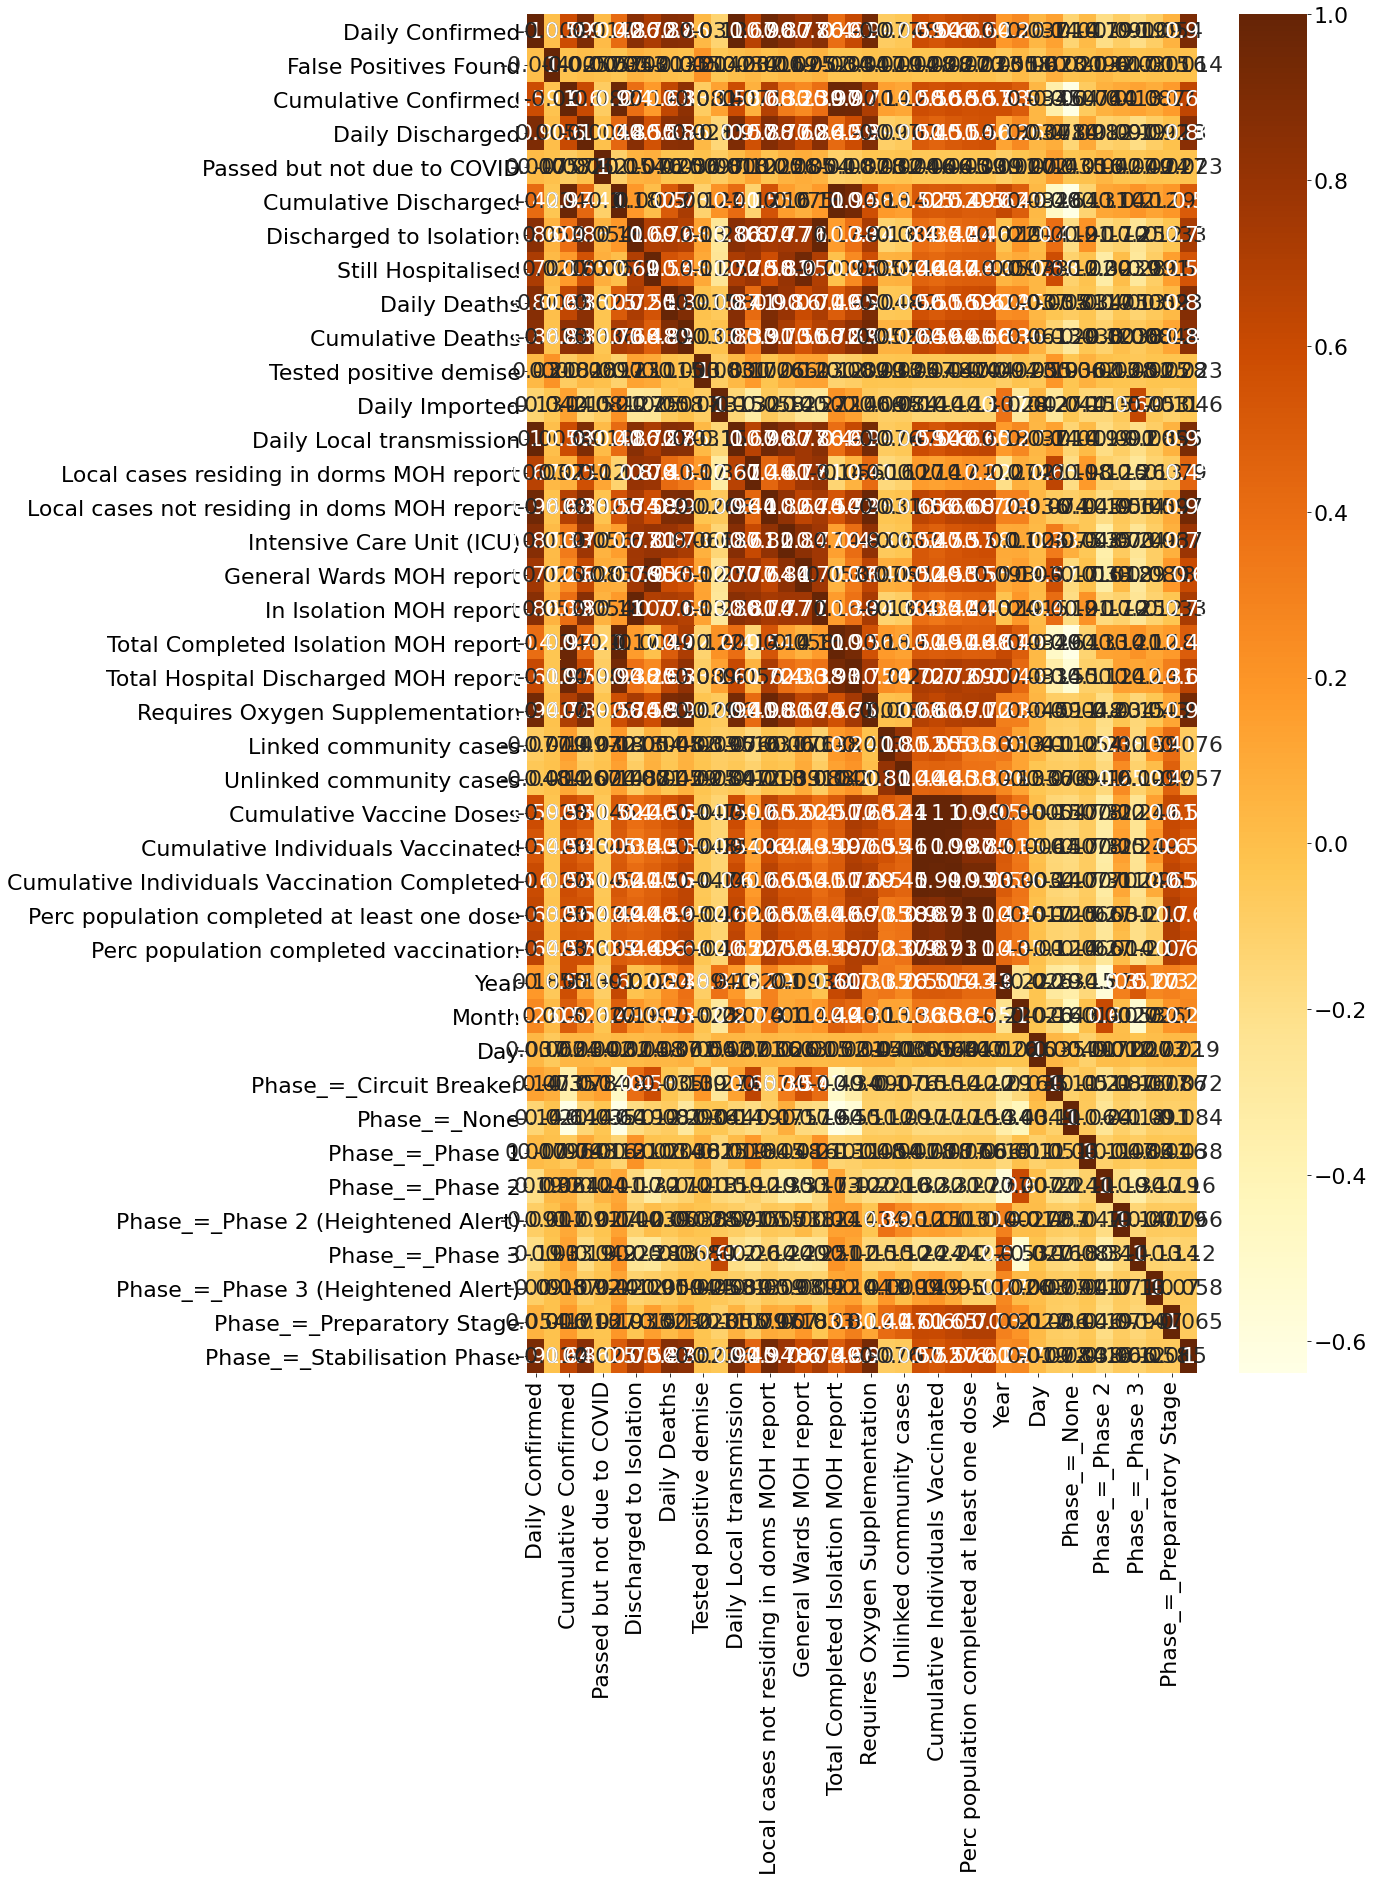

In [111]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [112]:
# understanding correlation of all variables to imported cases (can change accordingly to the variable you are trying to predict)

sg_data_filtered.corr()["Daily Confirmed"].sort_values(ascending=False)

Daily Confirmed                                 1.000000
Daily Local transmission                        0.999917
Local cases not residing in doms MOH report     0.961560
Requires Oxygen Supplementation                 0.936745
Phase_=_Stabilisation Phase                     0.911141
Daily Discharged                                0.903443
Intensive Care Unit (ICU)                       0.869249
Daily Deaths                                    0.869064
In Isolation MOH report                         0.859625
Discharged to Isolation                         0.858094
Cumulative Deaths                               0.856021
General Wards MOH report                        0.766798
Still Hospitalised                              0.721454
Local cases residing in dorms MOH report        0.669098
Perc population completed vaccination           0.644586
Perc population completed at least one dose     0.626025
Total Hospital Discharged MOH report            0.614403
Cumulative Individuals Vaccinat

In [113]:
# conduct PCA on preprocessed columns

# pca = PCA().fit(sg_data_filtered)

In [114]:
# pca.components_[0]

In [115]:
# find index of columns that make most contribution to variance captured

# include index of Daily Imported first
# important_indices = [11]

# for i in range(len(pca.components_[0])):
#     curr_comp = pca.components_[0][i]
#     if curr_comp > 0.0001:
#         important_indices.append(i)

In [116]:
# select the columns that are positively correlated to imported cases + PCA columns

# sg_data_final = sg_data_filtered.iloc[:, important_indices]

# Viewing Chart Pattern

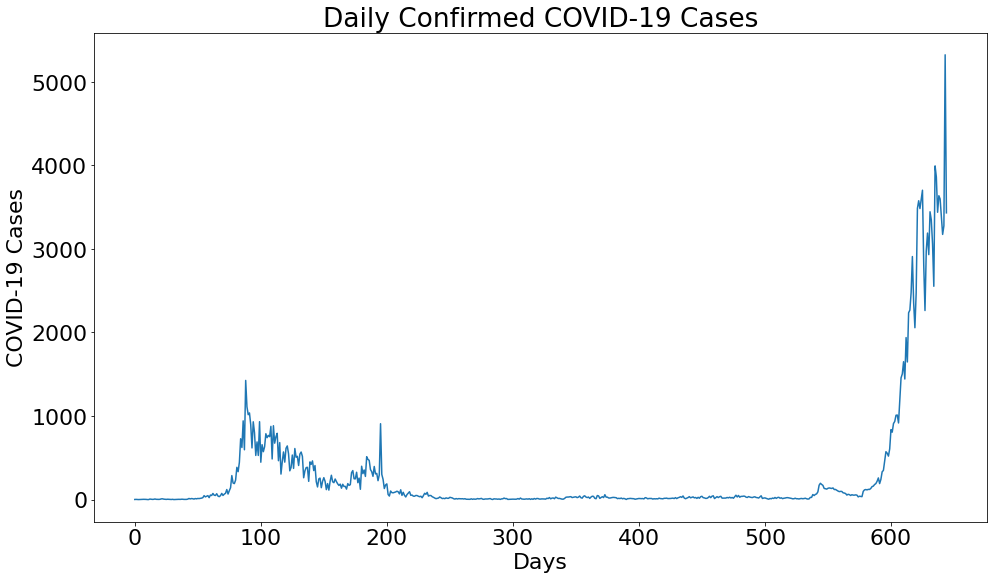

In [117]:
fig, ax = plt.subplots(figsize=(16,9))
sg_data_filtered["Daily Confirmed"].plot()
plt.title('Daily Confirmed COVID-19 Cases')
plt.xlabel('Days')
plt.ylabel('COVID-19 Cases')
plt.show()
fig.savefig('Daily_Confirmed_COVID-19_Cases.png')

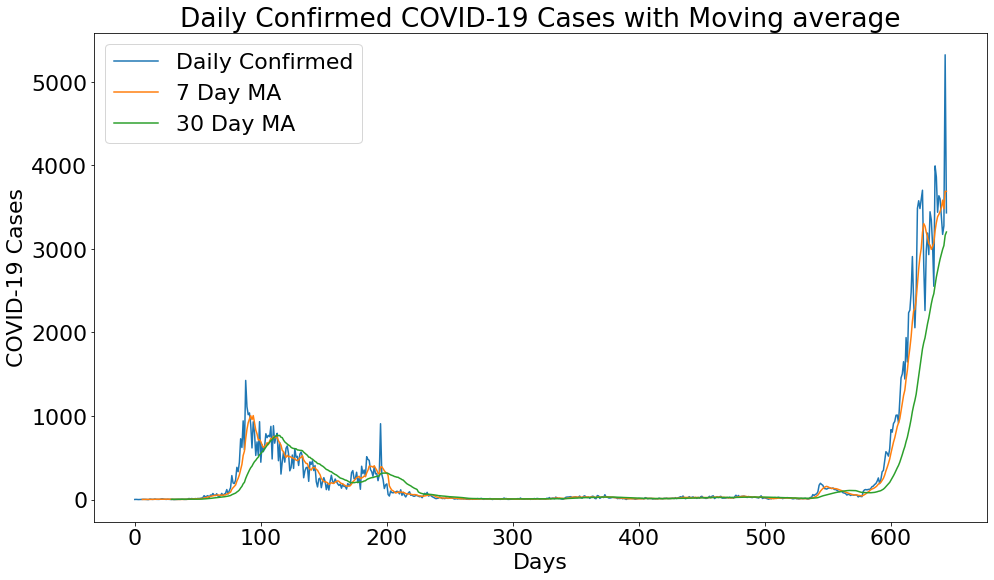

In [118]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(sg_data_filtered["Daily Confirmed"], label="Daily Confirmed")
ax.plot(sg_data_filtered["Daily Confirmed"].rolling(window=7).mean(), label="7 Day MA")
ax.plot(sg_data_filtered["Daily Confirmed"].rolling(window=30).mean(), label="30 Day MA")
ax.legend()
plt.title('Daily Confirmed COVID-19 Cases with Moving average')
plt.xlabel('Days')
plt.ylabel('COVID-19 Cases')
plt.show()
fig.savefig('Daily_Confirmed_COVID-19_Cases_with_Moving_average.png')

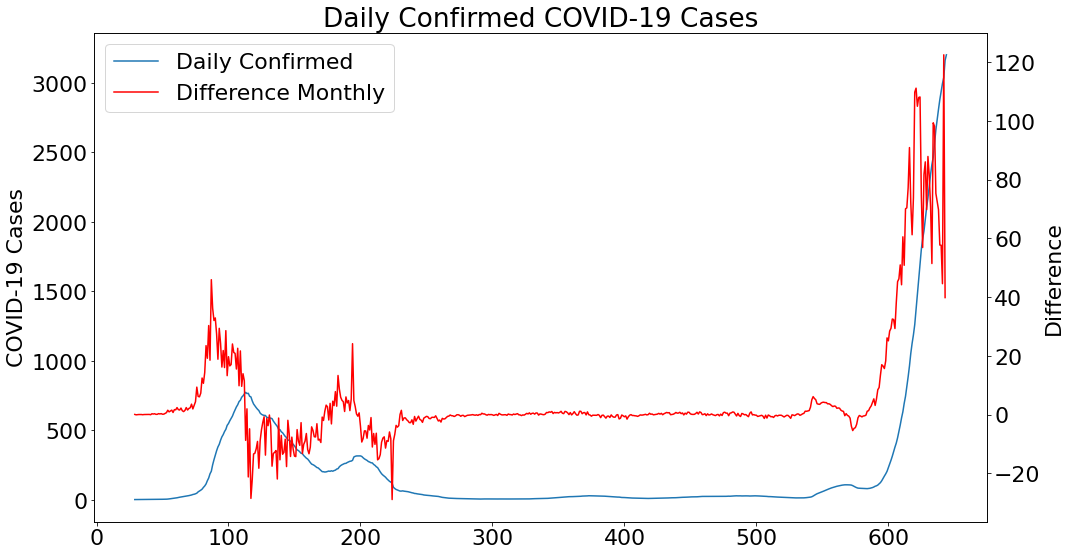

In [119]:
# shows inflection point
fig, ax = plt.subplots(figsize=(16,9))
ln1 = ax.plot(sg_data_filtered["Daily Confirmed"].rolling(window=30).mean(), label="Daily Confirmed")
ax.set_ylabel("COVID-19 Cases")
ax2 = ax.twinx()
ln2 = ax2.plot(np.diff(sg_data_filtered["Daily Confirmed"].rolling(window=30).mean()), label="Difference Monthly",color='red')
ax2.set_ylabel("Difference")
ax.legend(ln1+ln2,[x.get_label() for x in (ln1+ln2)])
plt.title('Daily Confirmed COVID-19 Cases')
plt.xlabel('Days')
plt.show()
fig.savefig('Daily_Confirmed_COVID-19_Cases_diff.png')

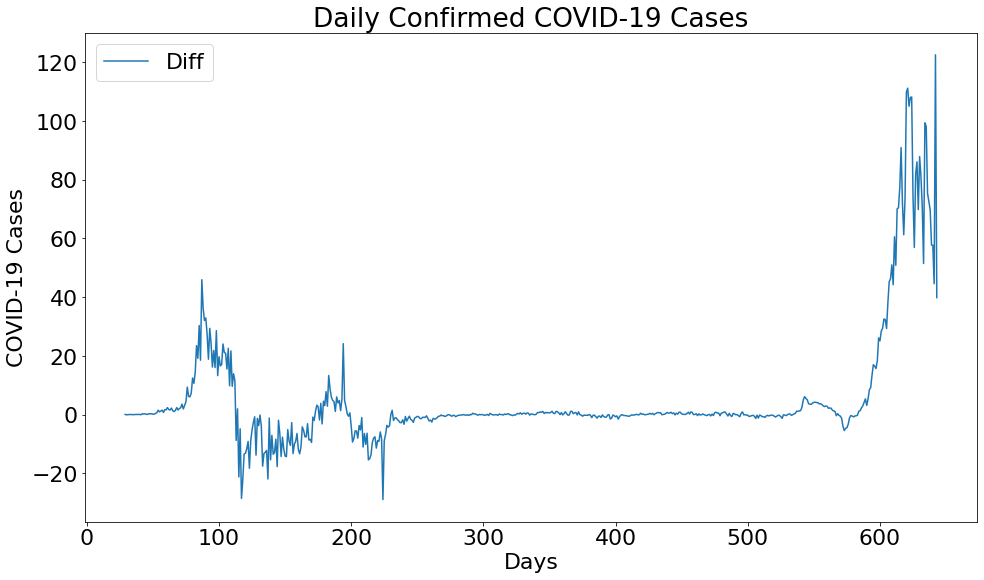

In [120]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.diff(sg_data_filtered["Daily Confirmed"].rolling(window=30).mean()), label="Diff")
ax.legend()
plt.title('Daily Confirmed COVID-19 Cases')
plt.xlabel('Days')
plt.ylabel('COVID-19 Cases')
plt.show()


# Train Test Split & KFold Cross Validation

In [121]:
# change y variable accordingly to what is of interest

X = sg_data_filtered.drop("Daily Confirmed", axis=1)
y = sg_data_filtered["Daily Confirmed"]

In [122]:
# split using 25% for test as amount of data isn't much so that we've got more points to test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [123]:

strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Linear Regression

In [124]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [125]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=strat_k_fold)), 4)}")

Evaluation Metrics for LR
MAE: 1.6035851167102564e-10
MSE: 8.497047477320734e-20
RMSE: 2.9149695499817375e-10
R-squared score for train: 1.0
Adjusted R-squared score for train: 1.0
R-squared score for test: 1.0
Adjusted R-squared score for test: 1.0
Cross Validation Score: 1.0


C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


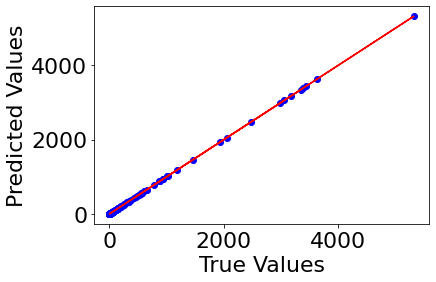

In [126]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

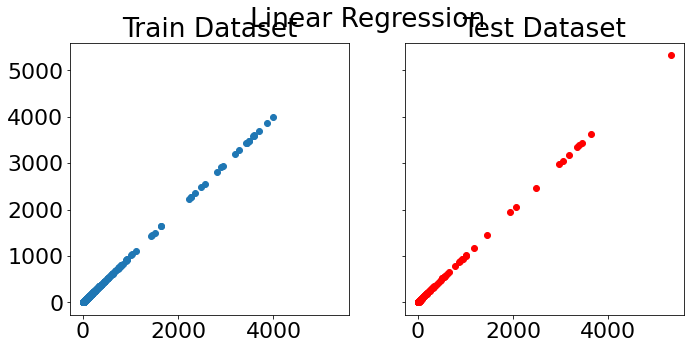

In [127]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [128]:
# find out feature importance

regr_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regression.coef_
})

regr_importance = regr_importance.sort_values(by='Importance', ascending=False)
regr_importance

,Attribute,Importance
10,Daily Imported,1.000000e+00
11,Daily Local transmission,1.000000e+00
6,Still Hospitalised,2.423131e-10
5,Discharged to Isolation,2.421665e-10
4,Cumulative Discharged,2.390017e-10
8,Cumulative Deaths,2.214970e-10
9,Tested positive demise,1.776229e-10
7,Daily Deaths,1.414238e-10
13,Local cases not residing in doms MOH report,1.991111e-11
12,Local cases residing in dorms MOH report,1.985099e-11


# Lasso Regression

In [129]:
# build lasso model

lasso = Lasso(max_iter=10000)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

NameError: name 'Lasso' is not defined

In [ ]:
# assessing model

train_adjusted_r2 = 1 - (1-lasso.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-lasso.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Lasso")
print(f"MAE: {mean_absolute_error(y_test, lasso_pred)}")
print(f"MSE: {mean_squared_error(y_test, lasso_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, lasso_pred))}")
print(f"R-squared score for train: {lasso.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {lasso.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(lasso, X, y, cv=strat_k_fold)), 4)}")

Evaluation Metrics for Lasso
MAE: 0.7406111313369326
MSE: 4.9835895381970055
RMSE: 2.232395470833294
R-squared score for train: 0.9999973133124784
Adjusted R-squared score for train: 0.9999971389683631
R-squared score for test: 0.9999899300030732
Adjusted R-squared score for test: 0.9999892765423741
Cross Validation Score: 1.0


C:\Users\wei-d\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


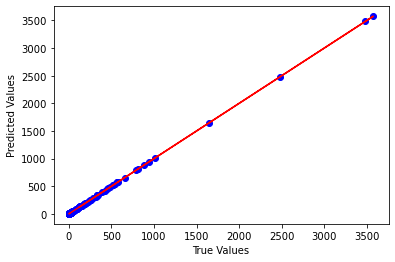

In [ ]:
# For test set

# scatter for predictions
plt.scatter(y_test, lasso_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

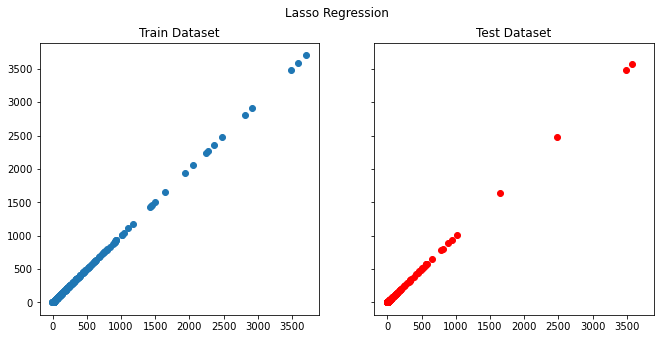

In [ ]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(lasso.predict(X_train), y_train)
ax[1].scatter(lasso_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Lasso Regression')

plt.show()

In [ ]:
# find out feature importance

lasso_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': lasso.coef_
})

lasso_importance = lasso_importance.sort_values(by='Importance', ascending=False)
lasso_importance

,Attribute,Importance
11,Daily Local transmission,9.983313e-01
10,Daily Imported,9.853702e-01
5,Discharged to Isolation,7.094597e-02
6,Still Hospitalised,7.015049e-02
1,Cumulative Confirmed,5.630696e-03
12,Local cases residing in dorms MOH report,2.443736e-03
2,Daily Discharged,2.323931e-05
23,Cumulative Individuals Vaccinated,1.638572e-06
24,Cumulative Individuals Vaccination Completed,7.430343e-08
33,Phase_=_Phase 2,0.000000e+00


# Ridge Regression

In [ ]:
ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

C:\Users\wei-d\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.05142e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [ ]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=strat_k_fold)), 4)}")

Evaluation Metrics for Ridge
MAE: 0.0004275938786755244
MSE: 1.6883962400952687e-06
RMSE: 0.001299383022859414
R-squared score for train: 0.9999999999975625
Adjusted R-squared score for train: 0.9999999999974043
R-squared score for test: 0.9999999999965884
Adjusted R-squared score for test: 0.999999999996367
Cross Validation Score: 1.0


C:\Users\wei-d\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\wei-d\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.41603e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\wei-d\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.57569e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\wei-d\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.47517e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\wei-d\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.57663e-1

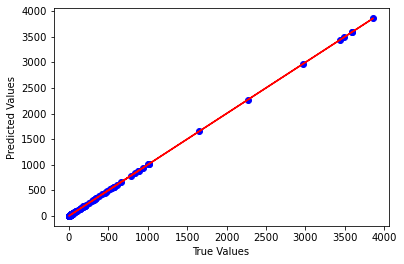

In [ ]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

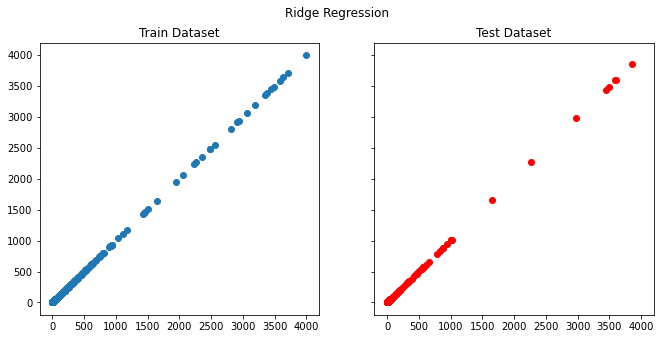

In [ ]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [ ]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
10,Daily Imported,9.999888e-01
11,Daily Local transmission,9.995292e-01
31,Phase_=_None,1.944166e-03
13,Local cases not residing in doms MOH report,4.707018e-04
12,Local cases residing in dorms MOH report,4.701655e-04
27,Year,4.164558e-04
1,Cumulative Confirmed,1.584061e-04
35,Phase_=_Phase 3,1.195155e-04
26,Perc population completed vaccination,7.179142e-05
14,Intensive Care Unit (ICU),6.772488e-05


# Important Features & Future Prediction

In [ ]:
important_X_train = X_train[["Daily Imported","Daily Local transmission","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_test = X_test[["Daily Imported","Daily Local transmission","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
